In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import pybdshadow
from shapely.geometry import Polygon

In [2]:
buildings = gpd.read_file(r'../example/data/bd_demo.json')
buildings

,id,height,x,y,geometry
0,0,42,139.698802,35.533816,"POLYGON ((139.69831 35.53380, 139.69831 35.533..."
1,1,9,139.698402,35.534030,"POLYGON ((139.69799 35.53417, 139.69799 35.533..."
2,2,45,139.698491,35.534637,"POLYGON ((139.69864 35.53445, 139.69863 35.534..."
3,3,9,139.698784,35.534735,"POLYGON ((139.69864 35.53477, 139.69866 35.534..."
4,4,90,139.700506,35.536064,"POLYGON ((139.70015 35.53590, 139.70039 35.535..."
...,...,...,...,...,...
1369,27826,5,139.708790,35.552112,"POLYGON ((139.70876 35.55223, 139.70869 35.552..."
1370,27827,43,139.706311,35.551746,"POLYGON ((139.70637 35.55183, 139.70621 35.551..."
1371,27828,16,139.705786,35.551667,"POLYGON ((139.70583 35.55179, 139.70572 35.551..."
1372,27829,14,139.708900,35.551267,"POLYGON ((139.70867 35.55133, 139.70867 35.551..."


In [3]:
from suncalc import get_position
date = pd.to_datetime('2015-01-01 02:45:33.959797119')
height = 'height'
ground = 0
epsg = 3857

building = buildings.copy()
building[height] -= ground
building = building[building[height] > 0]
# calculate position
lon1, lat1, lon2, lat2 = list(building.bounds.mean())
lon = (lon1+lon2)/2
lat = (lat1+lat2)/2
# transform coordinate system
building.crs = 'epsg:4326'
building = building.to_crs(epsg=epsg)
# obtain sun position
sunPosition = get_position(date, lon, lat)
buildingshadow = building.copy()
walls = []
for j in range(len(buildingshadow)):
    r = buildingshadow.iloc[j]
    wall = pd.DataFrame(list(r['geometry'].exterior.coords), columns=['x1', 'y1'])
    wall['x2'] = wall['x1'].shift(-1)
    wall['y2'] = wall['y1'].shift(-1)
    wall['height'] = r['height']
    wall = wall.iloc[:-1]
    wall['wall'] = wall.apply(lambda r: [[r['x1'], r['y1']],
                                        [r['x2'], r['y2']]], axis=1)
    walls.append(wall)
walls = pd.concat(walls)
walls_shape = np.array(list(walls['wall']))
shadowShape = pybdshadow.calSunShadow1(walls_shape,walls['height'].values,sunPosition)
walls['geometry'] = list(shadowShape)
walls['geometry'] = walls['geometry'].apply(lambda r:Polygon(r))
walls = gpd.GeoDataFrame(walls)
walls.crs = 'epsg:'+str(epsg)
shadows = walls.to_crs(epsg=4326)

In [19]:
pybdshadow.show_bdshadow(buildings = buildings,shadows = shadows)

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': '4eo0v3', 'type': '…

<AxesSubplot:>

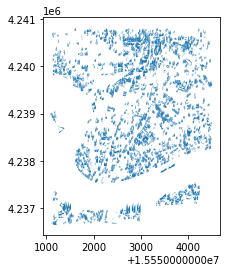

In [13]:
walls.plot()